In [1]:
#default_exp coco

# COCO
> Detail API

In [1]:
# export 
import json
import torch
import os
import os.path as osp
import shutil
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import mmcv
import numpy as np
import pandas as pd
from fastcore.script import *
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
from tqdm import tqdm
from avcv.visualize import show as av_show
from loguru import logger

In [17]:
# export
class AvCOCO(COCO):
    def __init__(self, annotation_file=None, verbose=False):
        """
        Constructor of Microsoft COCO helper class for reading and visualizing annotations.
        :param annotation_file (str): location of annotation file
        :param image_folder (str): location to the folder that hosts images.
        :return:
        """
        # load dataset
        self.dataset,self.anns,self.cats,self.imgs = dict(),dict(),dict(),dict()
        self.imgToAnns, self.catToImgs = defaultdict(list), defaultdict(list)
        self.verbose = verbose
        if not annotation_file == None:
            if verbose:
                logger.info('loading annotations into memory...')
            tic = time.time()
            if isinstance(annotation_file, str):
                with open(annotation_file, 'r') as f:
                    dataset = json.load(f)
            else:
                dataset = annotation_file
            assert type(dataset)==dict, 'annotation file format {} not supported'.format(type(dataset))
            if verbose:
                logger.info('Done (t={:0.2f}s)'.format(time.time()- tic))
            self.dataset = dataset
            self.createIndex()
            
            
    def createIndex(self):
        # create index
        if self.verbose:
            logger.info('creating index...')
        anns, cats, imgs = {}, {}, {}
        imgToAnns,catToImgs = defaultdict(list),defaultdict(list)
        if 'annotations' in self.dataset:
            for ann in self.dataset['annotations']:
                imgToAnns[ann['image_id']].append(ann)
                anns[ann['id']] = ann

        if 'images' in self.dataset:
            for img in self.dataset['images']:
                imgs[img['id']] = img

        if 'categories' in self.dataset:
            for cat in self.dataset['categories']:
                cats[cat['id']] = cat

        if 'annotations' in self.dataset and 'categories' in self.dataset:
            for ann in self.dataset['annotations']:
                catToImgs[ann['category_id']].append(ann['image_id'])
        if self.verbose:
            logger.info('index created!')

        # create class members
        self.anns = anns
        self.imgToAnns = imgToAnns
        self.catToImgs = catToImgs
        self.imgs = imgs
        self.cats = cats


class CocoDataset:
    def __init__(self, gt, img_dir=None, pred=None):
        if img_dir is None:
            assert isinstance(gt, str) and '/annotations/' in gt
            img_dir = gt.split('/annotations/')[0]+'/images'
            logger.info(f'Img dir is not set, set to :{img_dir}')
            assert osp.isdir(img_dir)
        if isinstance(gt, COCO):
            gt = gt.dataset
        self.gt = AvCOCO(gt)

        if isinstance(pred, str):
            pred = mmcv.load(pred)

        self.pred = self.gt.loadRes(pred) if pred is not None else None

        self.img_dir = img_dir
        self.img_ids = [_['id'] for _ in self.gt.imgs.values()]

    def imread(self, img_id, channel_order='bgr'):
        im = self.gt.imgs[img_id]
        img_path = osp.join(self.img_dir,im['file_name'])
        assert osp.exists(img_path), img_path
        return mmcv.imread(img_path, channel_order=channel_order)

    def visualize(self, img_id=None,  mode='gt', dpi=100, 
        show=False, anns=None, color='green', img=None, score_thr=0.3):
        if img_id is None:
            img_id = np.random.choice(self.img_ids)
            logger.info(f'Random visualize img_id={img_id}')
        if img is None:
            img= self.imread(img_id)

        if mode=='pred':
            assert self.pred is not None

        CLASSES = {cat_id:cat['name'] for cat_id, cat in self.gt.cats.items()}
        im = self.gt.imgs[img_id]
        source = self.pred if mode == 'pred' else self.gt

        if anns is None:
            anns  = source.loadAnns(source.getAnnIds(im['id']))

        bboxes = []
        lables = []
        for ann in anns:
            x1,y1,w,h = [int(_) for _ in ann['bbox']]
            x2 = x1+w
            y2 = y1+h
            score = ann.get('score', None)
            if score is not None:
                bboxes.append([x1,y1,x2,y2, score])
            else:
                bboxes.append([x1,y1,x2,y2])
            lables.append(ann['category_id'])

        bboxes = np.array(bboxes)
        lables = np.array(lables)

        if len(bboxes):
            img = mmcv.visualization.imshow_det_bboxes(img, bboxes, 
                lables, CLASSES, show=False, bbox_color=color, text_color=color, 
                score_thr=score_thr)
        if show:
            av_show(img[...,::-1], dpi=dpi)
        return img

    def load_anns(self, img_id, source=None):
        if source is None:
            source = self.gt
        anns = source.loadAnns(source.getAnnIds(img_id))
        return anns

    def evaluate(self, *args, **kwargs):
        cocoEval = COCOeval(self.gt, self.pred, 'bbox')
        cocoEval.evaluate()
        cocoEval.accumulate()
        cocoEval.summarize()

## Function utils

In [18]:
#export
def get_bboxes(anns, mode='xywh', dtype=None, score_thr=None):
    bboxes = []
    for ann in anns:
        if score_thr is not None and ann.get('score', False):
            if ann['score'] < score_thr:
                continue
        x,y,w,h = ann['bbox']
        if mode == 'xywh':
            bboxes.append([x,y,w,h])
        elif mode == 'xyxy':
            bboxes.append([x,y,x+w,y+h])
    bboxes = np.array(bboxes)
    if dtype is not None:
        bboxes = bboxes.astype(dtype)

    return bboxes

def get_overlap_rate(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    iou = interArea / float(boxAArea)
    return iou

# Evaluate 

In [19]:
#export
class DiagnoseCoco(CocoDataset):
    COLORS = dict(
        FN='red', # Undetected GT
        FP='yellow', # Wrong detection
    )

    def find_false_samples(self, img_id, score_thr=0.05, visualize=True):
        from mmcv.ops import bbox_overlaps
        assert self.gt is not None
        assert self.pred is not None
        pred_anns = [ann for ann in self.pred.loadAnns(self.pred.getAnnIds(img_id)) if ann['score']>score_thr]
        gt_anns = self.gt.loadAnns(self.gt.getAnnIds(img_id))

        pred_bboxes = get_bboxes(pred_anns, mode='xyxy')
        pred_bboxes = torch.from_numpy(pred_bboxes).cuda().float()

        gt_bboxes = get_bboxes(gt_anns, mode='xyxy')
        gt_bboxes = torch.from_numpy(gt_bboxes).cuda().float()
        with torch.no_grad():
            ious = bbox_overlaps(pred_bboxes, gt_bboxes).cpu().numpy()
        mapping_gt_pred = np.where(ious>0)

        result = dict(tp=[], fn=[], fp=[])

        gt_ids = list(range(len(gt_anns)))
        pred_ids = list(range(len(pred_anns)))
        for pred_id, gt_id in zip(*mapping_gt_pred):
            if gt_anns[gt_id]['category_id'] == pred_anns[pred_id]['category_id']:
                result['tp'].append(pred_anns[pred_id])
                if gt_id in gt_ids:
                    gt_ids.remove(gt_id)
                if pred_id in pred_ids:
                    pred_ids.remove(pred_id)


        result['fp'] = [pred_anns[i] for i in  pred_ids]
        result['fn'] = [gt_anns[i] for i in gt_ids]
        if visualize:
            vis_img = self.visualize(img_id, anns=result['fn'], color=self.COLORS['FN'], show=False)
            vis_img = self.visualize(img_id,  anns=result['tp'],img=vis_img, show=False,)
            vis_img = self.visualize(img_id, anns=result['fp'], dpi=150,color=self.COLORS['FP'], show=False, img=vis_img)
            vis_img = vis_img[...,::-1].copy()
            result['vis_img'] = vis_img
        return result

# Utils
## Video to coco folder

In [20]:
# export
from avcv.utils import video_to_images, multi_thread, get_name
import os.path as osp
from glob import glob
from functools import partial
from PIL import Image


def video_to_coco(
    input_video,
    test_json,
    output_dir=None,
    skip=1
):

    assert os.path.exists(input_video), f'{input_video} does not exist'
    def path2image(path, root_dir):
        w, h = Image.open(path).size
        name = path.replace(root_dir, '')
        if name.startswith('/'):
            name = name[1:]
        return dict(
            file_name=name, height=h, width=w
        )
    

    if output_dir is None:
        output_dir = osp.join('.cache/video_to_coco', get_name(input_video))
        logger.info(f'Set output dir to->{output_dir}')

    image_out_dir = osp.join(output_dir, 'images')

    if osp.isdir(input_video):
        os.symlink(input_video)
        

    image_dir_name = osp.normpath(image_out_dir).split('/')[-1]
    path_out_json = osp.join(output_dir, f'annotations/{image_dir_name}.json')

    mmcv.mkdir_or_exist(osp.dirname(path_out_json))
    mmcv.mkdir_or_exist(image_out_dir)
    source_type = 'dir' if osp.isdir(input_video) else 'video'
    logger.info(f'Generating images from {source_type}: {input_video} ->  {osp.abspath(output_dir)}')
    if not osp.isdir(input_video):
        video_to_images(input_video, image_out_dir)
        
    paths = glob(osp.join(image_out_dir, '*'))
    out_dict = dict(images=[], annotations=[],
                    categories=mmcv.load(test_json)['categories'])
    out_dict['images'] = list(
        map(partial(path2image, root_dir=image_out_dir), sorted(paths)))

    for i, image in enumerate(out_dict['images']):
        image['id'] = i
    mmcv.dump(out_dict, path_out_json)
    return os.path.normpath(path_out_json), os.path.normpath(image_out_dir)




## Example

In [21]:
ls .cache/video_to_coco/hcm_5s/

annotations/ images/


2021-11-13 00:06:35.436 | INFO     | __main__:video_to_coco:29 - Set output dir to->.cache/video_to_coco/hcm_5s
2021-11-13 00:06:35.438 | INFO     | __main__:video_to_coco:43 - Generating images from video: ../asset/hcm_5s.mp4 ->  /Users/bi/avcv/nbs/.cache/video_to_coco/hcm_5s


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 50/50, 59.1 task/s, elapsed: 1s, ETA:     0s

2021-11-13 00:06:36.839 | INFO     | __main__:__init__:68 - Img dir is not set, set to :.cache/video_to_coco/hcm_5s/images
2021-11-13 00:06:36.840 | INFO     | __main__:visualize:92 - Random visualize img_id=40


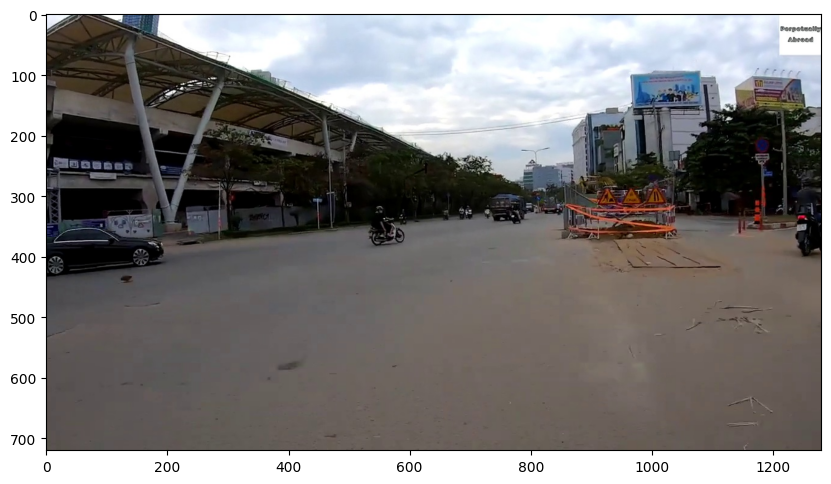

In [22]:
json_path, image_idr = video_to_coco('../asset/hcm_5s.mp4', '/Users/bi/data/tsd/unlabled_videos/annotations/path.json')
ds = CocoDataset(json_path)
ds.visualize(show=1, dpi=100);

In [23]:
# ds.gt.imgs

## CLI

In [24]:
#export
@call_parse
def v2c(input_video: Param("path to video", str),
        test_json: Param("path to annotation json path, to get the category", str),
        output_dir: Param("", str) = None,
        skip: Param("", int) = 1
        ):
    return video_to_coco(input_video, test_json, output_dir, skip)


In [25]:
!cd ~/avcv && nbdev_build_lib && pip install -e ./

Converted 00_visualize.ipynb.
Converted 01_process.ipynb.
Converted 03_utils.ipynb.
Converted 04_debug.ipynb.
Converted 05_coco_dataset.ipynb.
Converted index.ipynb.
Obtaining file:///Users/bi/avcv
  Attempting uninstall: avcv
    Found existing installation: avcv 0.0.17
    Uninstalling avcv-0.0.17:
      Successfully uninstalled avcv-0.0.17
  Running setup.py develop for avcv
